# Complexity Scheduling -- Autoencoder Depth Scheduling

This notebook contains an exploration of model architecture complexity scheduling for autoencoder training.

The idea is to train a very shallow autoencoder such that is learns a simple large latent representation of an image. Then, after training of this initial model has concluded, a new layer is appened to the output of the encoder and to the input of the decoder. Thus deepening the network, with the possibility of reducing the size of the compression as well. This is a form of transfer learning where the shallower model is meant to reduce the difficulty of training the deeper version of it by being a part of it.

In this notebook, I develop an implementation of Depth Scheduling for an mnist autoencoder. An important thing to note here is that the mnist is a relatively simple dataset to build an autencoder on. The point of this notebook is not to seek a more optimized mnist autoencoder. Rather, it is to design the software requirements for accomplishing this task on more complex image datasets. 

One of the reasons for choosing Autoencoders specifically for this project is to further explore autoencoder pretraining of more complex GANs.

In [2]:
from tensorflow import keras
from keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout, Reshape
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


Here we load in and normalize the mnist dataset. We are not using the labels because in an encoder the labels take the form of the features that were input into the model. This is because an autoencoder is meant to output its input after compressing it.

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()  #because we are training an autoencoder, we do not need labels. training data will be our label
x_train, x_test = x_train / 255, x_test / 255  #Normmalize the data 

print("Training data shape:", x_train.shape)
print("Testing data shape:", x_test.shape) 

11490434/11490434 [==============================] - 0s 0us/step
Training data shape: (60000, 28, 28)
Testing data shape: (10000, 28, 28)


# Necessary Functions

Below we define five funtions that facilitate the autoencoder depth scheduling training method. They are as follows:

initial_model()  
deepen_autoencoder()  
define_model()  
complexity_scheduling()  
plot_pred()  
 
initial_model() defines the initial shallow autoencoder. it contains the parameter initial_nodes=200 which specifies the number of neurons of which the model compresses the flattened mnist digit into. Both the encoder and the decoder are defined seperately using the Keras Functional API and then used to define the autoencoder before being returned. This is important because it means that the encoder and the decoder are both being treated as single layers. This means that we can retrieve and expand upon them in the deepen_autoencoder() function.

deepen_autoencoder() is fed the old_model, of which it seperates out the encoder and the decoder. The encoder recieves a new layer directly following its output. The decoder recieves a new layer directly preceeding its input. This results in a new model that is two layers deeper, with all the same weights as before, except for the new randomly initialized weights in the layers bordering the encoder and the decoder. This means the adjusted task for the net is to figure out how to create a mapping from the old encoder output through the new decoder output and new encoder input such that the old encoder input is the same as it would be in the old model. The previous sentence is extremely important for understanding the purpose of training the model this way. It reduces the task of training a deep neural net to just finding this two layer mapping (assuming the initial model is also successful). Currently, the added layers are of the same number of neurons as the initial model's Dense layers, this can be changed easily depending on the use case.

define_model() acts as a logic gate within the complexity_scheduling() function to determine whether to call initial_model() or deepen_autoencoder() depending on if old_model is passed in as an argument. The model that results from either of these two function calls is then compiled, its stats are printed, and returned along with the adjusted learning rate. A further note on the lr given this specific implementation is that lr scheduling is easy to throw in on top of depth scheduling. In this case, the lr is reduced by a factor of 10x after training has concluded for each depth version. 

complexity_scheduling() is the mastermind behind implementing the prior three functions in proper order. the layers_to_train param specifies the number of depth additions to add to the encoder/decoder. Training of each model iteration is carried out within the main for loop of the function. First, define_model() is called, which returns a model and the current lr. Then that model is trained. Following training, the performance of the model is saved to the training_performance dict. This is repeated for each iteration of the for loop. Once the for loop has concluded, the model is recompiled with a lower learning rate and fine tuned with another round of training. The final model along with the training_history is returned. 

plot_pred() plots the input output mapping of the auto_encoder.

In [4]:
def initial_model(initial_nodes=200):
    #define encoder
    encoder_input = Input(shape=(28, 28)) 
    x = Flatten()(encoder_input)
    x = Dropout(0.15)(x)
    encoder_output = Dense(initial_nodes, activation="selu")(x)
    encoder = Model(encoder_input, encoder_output, name="encoder")

    # Define decoder
    decoder_input = Input(shape=(initial_nodes,)) 
    x = Dense(initial_nodes, activation="selu")(decoder_input)
    x = Dropout(0.15)(x)
    x = Dense(28 * 28, activation="sigmoid")(x)
    decoder_output = Reshape([28, 28])(x)
    decoder = Model(decoder_input, decoder_output, name="decoder")

    # Define autoencoder = encoder + decoder
    autoencoder_input = Input(shape=(28, 28))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    return Model(autoencoder_input, decoded) #return autoencoder

deepen_autoencoder() is fed the old_model, of which it seperates out the encoder and the decoder. The encoder recieves a new layer directly following its output. The decoder recieves a new layer directly preceeding its input. This results in a new model that is two layers deeper, with all the same weights as before, except for the new randomly initialized weights in the layers bordering the encoder and the decoder. This means the adjusted task for the net is to figure out how to create a mapping from the old encoder output through the new decoder output and new encoder input such that the old encoder input is the same as it would be in the old model. The previous sentence is extremely important for understanding the purpose of training the model this way. It reduces the task of training a deep neural net to just finding this two layer mapping (assuming the initial model is also successful). Currently, the added layers are of the same number of neurons as the initial model's Dense layers, this can be changed easily depending on the use case.

In [5]:
def deepen_autoencoder(old_model, initial_nodes=200):
    # add depth to the end of the encoder
    encoder = old_model.get_layer("encoder") #retrieve encoder from old model
    encoder_input = encoder.input  #set input of new encoder to be the same as old encoder
    x = encoder.output #get old encoder output
    x = Dense(initial_nodes, activation="selu")(x) #feed output of old enocder into new layer
    new_encoder = Model(encoder_input, x, name="encoder") #redefine model

    # add depth to the beginning of the decoder
    decoder = old_model.get_layer("decoder") #retrieve decoder from old model
    new_encoder_input = Input(shape=(initial_nodes,)) #specify new input for new decoder
    x = Dense(initial_nodes, activation="selu")(new_encoder_input) #specifiy new first layer for new decoder
    decoder_output = decoder(x) #feed output of added initial layer to old decoder
    new_decoder = Model(new_encoder_input, decoder_output, name="decoder") #redefine model

    # Define autoencoder = encoder + decoder
    autoencoder_input = Input(shape=(28, 28))
    encoded = new_encoder(autoencoder_input) #feed new encoder output tensor to new decoder
    decoded = new_decoder(encoded)
    return Model(autoencoder_input, decoded) #return deepened autoencoder after defining model
    

define_model() acts as a logic gate within the complexity_scheduling() function to determine whether to call initial_model() or deepen_autoencoder() depending on if old_model is passed in as an argument. The model that results from either of these two function calls is then compiled, its stats are printed, and returned along with the adjusted learning rate. A further note on the lr given this specific implementation is that lr scheduling is easy to throw in on top of depth scheduling. In this case, the lr is reduced by a factor of 10x after training has concluded for each depth version. 


In [6]:
def define_model(old_model=None, iter=0, initial_nodes=200, lr=0.001):

    lr = float(lr / 10) #low lr by 10x each iteration

    if old_model is not None:  #if there is a previous model, get it and deepen it
        auto_encoder = deepen_autoencoder(old_model)
    else: #otherwise, create initial model
        auto_encoder = initial_model(initial_nodes=initial_nodes)

    auto_encoder.compile(optimizer=Adam(learning_rate=(lr)), loss='mean_squared_error') #compile with MSE (pixel pred is regression)
    print(f'Learning rate for model with {iter} added depth: {lr}')

    return auto_encoder, lr

complexity_scheduling() is the mastermind behind implementing the prior three functions in proper order. the layers_to_train param specifies the number of depth additions to add to the encoder/decoder. Training of each model iteration is carried out within the main for loop of the function. First, define_model() is called, which returns a model and the current lr. Then that model is trained. Following training, the performance of the model is saved to the training_performance dict. This is repeated for each iteration of the for loop. Once the for loop has concluded, the model is recompiled with a lower learning rate and fine tuned with another round of training. The final model along with the training_history is returned. 

In [24]:
def complexity_scheduling(epochs=10000, layers_to_train=5, lr=0.001): #earlystopping will self regulate epochs
    training_performance, model = {}, None #initialize performance history dict and model

    for i in range(layers_to_train):
        #create, compile, and train new/next model 
        iter = i + 1

        model, lr = define_model(model, iter, lr=lr) #define original model / deepen existing model and collect current lr
        
        model.fit(x_train, x_train, epochs=epochs, validation_data=(x_test, x_test),
                            verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

        training_performance[i] = model.evaluate(x_test, x_test, verbose=0) #save performace to dict
        print(f'Score for {i+1} added depth: {training_performance[i]} \n')  
        
    #Recompile final mode to lower learning_rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0000001), loss='mean_squared_error')
    model.fit(x_train, x_train, epochs=epochs, validation_data=(x_test, x_test),
                            verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])
    
    training_performance[layers_to_train] = model.evaluate(x_test, x_test, verbose=0) #get final score
    print(f'Score after fine tuning: {training_performance[layers_to_train]}')
        
    return model, training_performance

plot_pred() plots the input output mapping of the auto_encoder.

In [19]:
def plot_pred(auto_encoder):
    pred = auto_encoder.predict(x_test[0].reshape(1, 28, 28)) #predict on first test image

    #plot real against decoded 
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[0], cmap='gray')
    plt.title('Real')
    plt.subplot(1, 2, 2)
    plt.imshow(pred.reshape(28, 28), cmap='gray')
    plt.title('Decoded')
    plt.show()

# 1 Layer Added

Below are some tests of calling complexity_scheduling() with different arguments passed into the layers_to_train parameter. 

Something to note is that the MSE actually slightly worsened by following this process. I suspect this has to do with the mnist dataset not needing an extremely deep encoder decoder network to accomplish good results in the first place. The increase in MSE is most likely a small amount of oferfitting that has accumulated amoung the layers. However, it is important to recognize that the overfitting is particularly small when you consider just how deep the model is. This method is essentially to build and autoencoder that maps the output of an encoder to the input of decoder. It's possible that the autoencoder could reach a very large depth while not sacrificing much performance given enough time and compute. 

In [25]:
auto_encoder, training_performance = complexity_scheduling(layers_to_train=1)

Learning rate for model with 1 added depth: 0.0001
Score for 1 added depth: 0.0030036333482712507 

Score after fine tuning: 0.002908264519646764


1/1 [==============================] - 0s 60ms/step


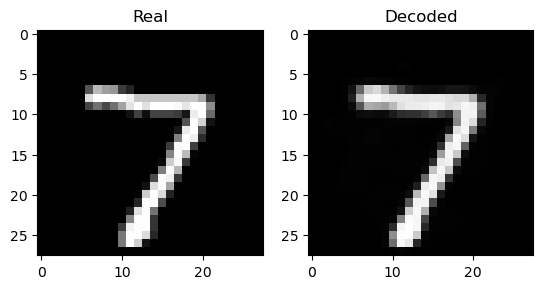

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 200)               157000    
                                                                 
 decoder (Functional)        (None, 28, 28)            197784    
                                                                 
Total params: 354,784
Trainable params: 354,784
Non-trainable params: 0
_________________________________________________________________


In [26]:
plot_pred(auto_encoder)
auto_encoder.summary()

# 2 Layers Added

In [27]:
auto_encoder, training_performance = complexity_scheduling(layers_to_train=2)

Learning rate for model with 1 added depth: 0.0001
Score for 1 added depth: 0.003134261816740036 

Learning rate for model with 2 added depth: 1e-05
Score for 2 added depth: 0.003211931325495243 

Score after fine tuning: 0.0031799909193068743


1/1 [==============================] - 0s 73ms/step


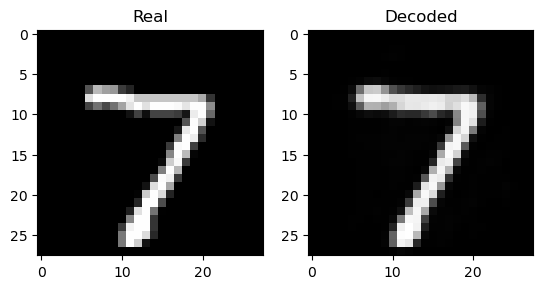

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 200)               197200    
                                                                 
 decoder (Functional)        (None, 28, 28)            237984    
                                                                 
Total params: 435,184
Trainable params: 435,184
Non-trainable params: 0
_________________________________________________________________


In [29]:
plot_pred(auto_encoder)
auto_encoder.summary()

# 3 Layers Added

In [30]:
auto_encoder, training_performance = complexity_scheduling(layers_to_train=3)

Learning rate for model with 1 added depth: 0.0001
Score for 1 added depth: 0.003053981112316251 

Learning rate for model with 2 added depth: 1e-05
Score for 2 added depth: 0.0032669859938323498 

Learning rate for model with 3 added depth: 1.0000000000000002e-06
Score for 3 added depth: 0.0037397011183202267 

Score after fine tuning: 0.0037330531049519777


1/1 [==============================] - 0s 83ms/step


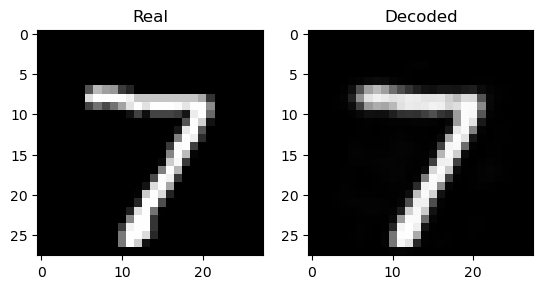

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 200)               237400    
                                                                 
 decoder (Functional)        (None, 28, 28)            278184    
                                                                 
Total params: 515,584
Trainable params: 515,584
Non-trainable params: 0
_________________________________________________________________


In [32]:
plot_pred(auto_encoder)
auto_encoder.summary()